## in this notebook we present our work by Abdelhak Heroucha and Walid Guettala for data maining using Logistic Regression.

<hr >

# Contents

## 1) Prepare Problem

 * Load libraries

 * Load and explore the shape of the dataset

## 2) Summarize Data

* Descriptive statistics

* Data visualization

## 3) Prepare Data

* Data Cleaning

* Split-out validation dataset

*  Data transformation  

## 4) Evaluate Algorithms


<hr />

## 1. Prepare Problem

### Loading the libraries 

Let us first begin by loading the libraries that we'll use in the notebook

In [ ]:
# numpy we use it for matrix operation 
import numpy as np
#pandas we use it for data frames and manupilation of the data
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

### defining the LogisticRegression1 class and outliers remove

In [ ]:
class LogisticRegression1:
    def __init__(self, x, y): 
        ones = np.ones((x.shape[0], 1))  
        # to have var with 1 and mean with 0 
        self.scaler = StandardScaler().fit(x)
        x = self.scaler.transform(x)
        self.x = np.concatenate((ones, x), axis=1)

        self.weight = 0.01 * np.random.randn(self.x.shape[1])
        self.y = y
         
    #Sigmoid method
    def sigmoid(self, x, weight):
        z = np.dot(x, weight)
        return 1 / (1 + np.exp(-z))
     
    #method to calculate the Loss
    def loss(self, y_pred, y):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()
     
    #Method for calculating the gradients
    def gradient_descent(self, X, y_pred, y):
        return np.dot(X.T, (y_pred - y)) / y.shape[0]

     
    def fit(self, lr , iterations):
        self.losses = np.zeros(iterations)
        
        for i in range(iterations):
            y_pred = self.sigmoid(self.x, self.weight)
             
            self.losses[i] = self.loss(y_pred, self.y)
 
            dW = self.gradient_descent(self.x , y_pred, self.y)
             
            #Updating the weights
            self.weight -= lr * dW
 
     # w = w - lear * dw
    #Method to predict the class label.
    def predict(self, x_test , threshold):
        x_test = self.scaler.transform(x_test)
        x_test = np.concatenate((np.ones((x_test.shape[0], 1)) , x_test), axis=1)
        
        result = self.sigmoid(x_test, self.weight)

        y_pred = np.array(result >= threshold, dtype=np.int32)
                
        return y_pred
    
    def loss_pre(self, x_test, y_test):
        x_test = self.scaler.transform(x_test)
        x_test = np.concatenate((np.ones((x_test.shape[0], 1)) , x_test), axis=1)
        
        y_pred = self.sigmoid(x_test, self.weight)
        
        loss = self.loss(y_pred, y_test)
        
        return loss

In [ ]:
def outlier_remove(df, repeated = 1):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than or equal 1 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >= repeated)
    
    return multiple_outliers   


### Loading and exploring the shape of the dataset

In [ ]:
#import my dataset
df = pd.read_csv(r'/home/walid/Desktop/data/rain/archive/weatherAUS.csv')

#print the head (first 5 instances of the data (rows) )
#we can see we have 23 features with missing values like in features ('Evaporation', 'Sunshine')
df.head()

/content/gdrive/My Drive/kaggle
  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 63.4MB/s]
Archive:  weather-dataset-rattle-package.zip
replace weatherAUS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: weatherAUS.csv          


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df = pd.read_csv(r'weatherAUS.csv')
df.shape

(145460, 23)

In [ ]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

## 2. Summarize data

### Descriptive statistics

Let's first summarize the distribution of the numerical 
variables. 

In [ ]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


The features are not on the same scale. For example Pressure9am has a mean of 1017.64994 while Rainfall has a mean value of 2.360918. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check the distribution of the data types.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


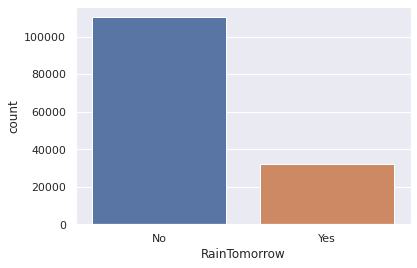

In [ ]:
sns.countplot(df['RainTomorrow'])
plt.show()

In [ ]:
#we can see we have unbalanced date 
df.groupby('RainTomorrow')['RainTomorrow'].count() / df.shape[0]

RainTomorrow
No     0.758394
Yes    0.219146
Name: RainTomorrow, dtype: float64

The dataset is pretty unbalanced. The instances of class No (0) constitute more than 75 % while class Yes (1) with only 21 %, in other hand we can see the sum of the No class and Yes class don't give us 100% that mean theri is missing values in this target column , we must drop them in the next title Prepare Data .

In [ ]:
df.shape

(145460, 23)

In [ ]:
#now we are trying to find percntage of missing values in the data for every column
missing_per = (df.isnull().sum() / df.shape[0] * 100)
missing_per

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

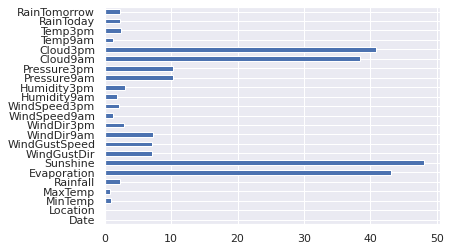

In [ ]:
#do a plot to undrstande missing values perecntage in the data
missing_per.plot(kind='barh');

we can see that target column (RainTomorrow) got 2% of missing values and this is what we find in the previous cell, and we can see we got a lot of missing values in every columns, while the big columns that got more then 38% of missing values are ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], and from the plot we can see more clear the big columns thaagot missing values , the columns that got more then 38% missing values need to be droped in next chapiter.

###  Data Visualization

Let's go ahead an look at the distribution of the different features of this dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


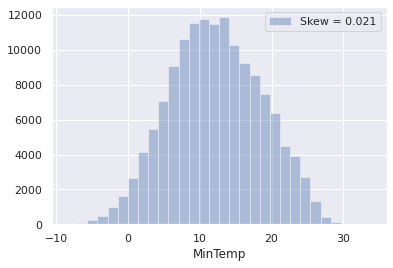

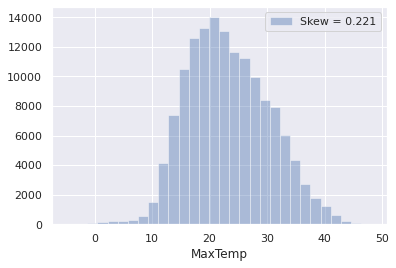

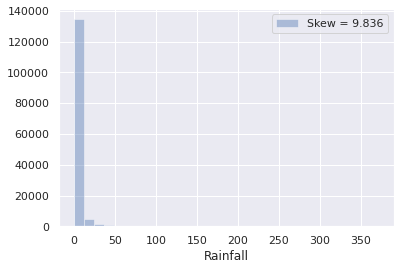

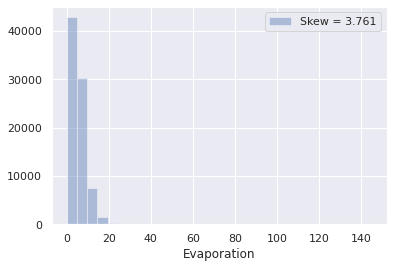

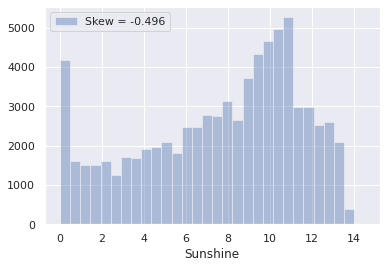

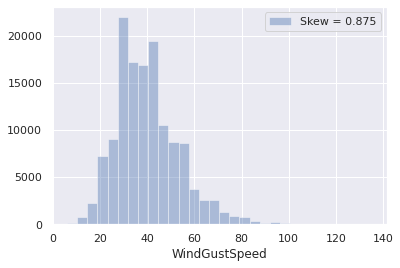

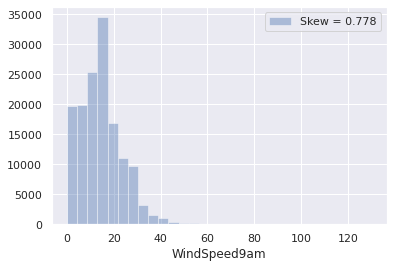

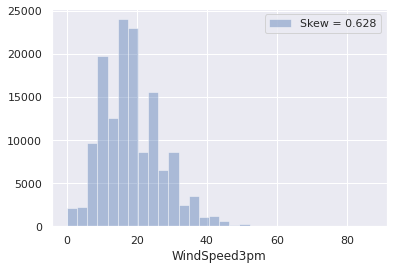

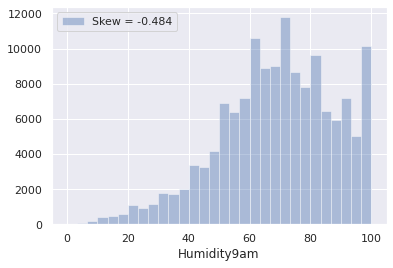

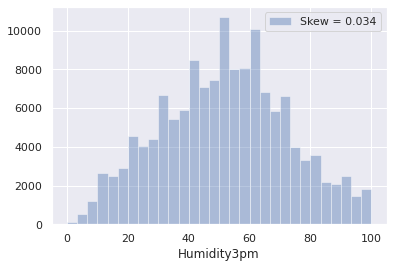

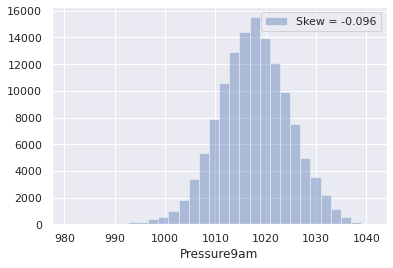

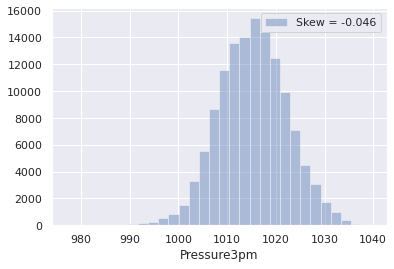

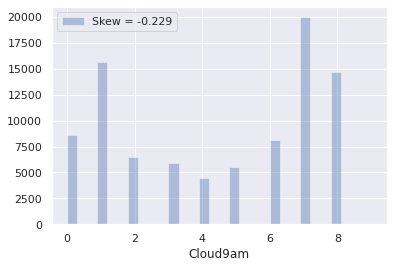

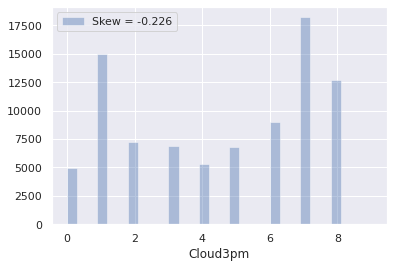

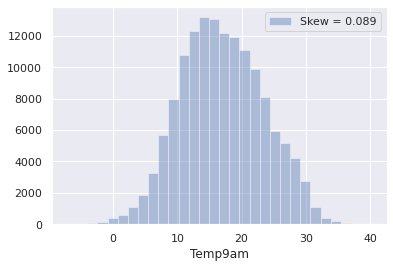

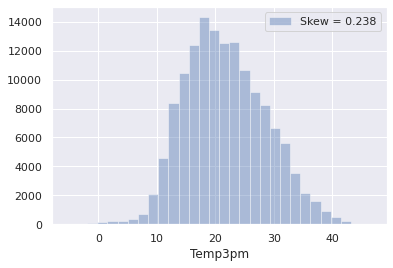

In [ ]:
for feat in df.columns:
    if df[feat].dtype != np.object:
        skew = df[feat].skew()
        sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
        plt.legend(loc='best')
        plt.show()

we can see most of the features are normally distributed, and some features like Rainfall and Evaporation are got little skwed so we will ingnore them for now 

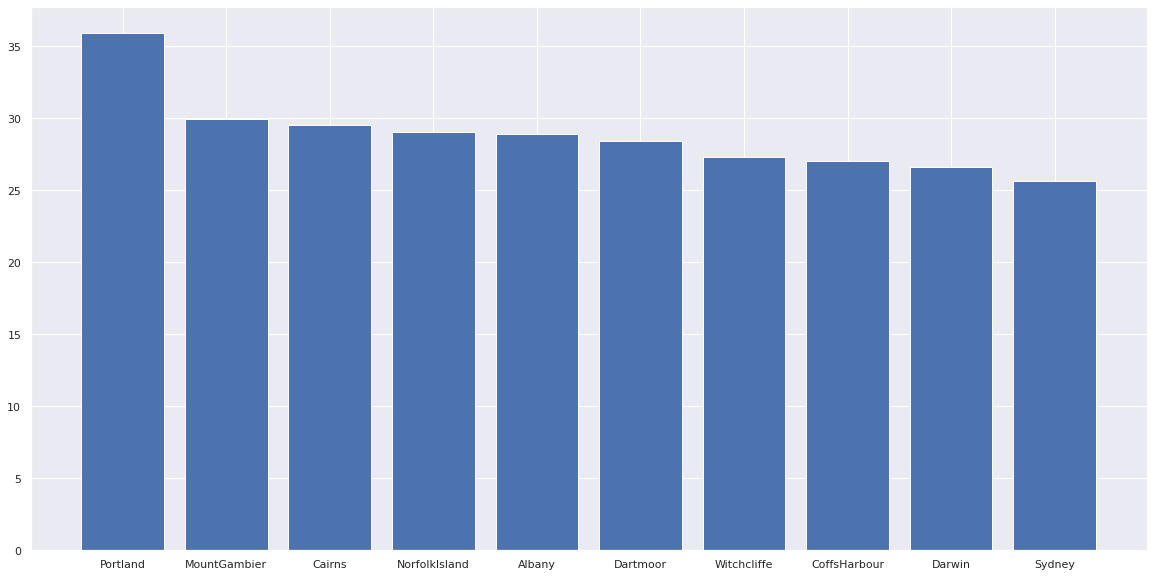

In [ ]:
#set index by year 
df['year'] = df['Date'].apply(lambda x : x[:4])
df['RainT'] = df['RainTomorrow'].astype('category').cat.codes
rainByLocation = df.groupby(['Location'])['RainT'].mean()

df.drop(['year', 'RainT'], axis=1, inplace = True)

rainByLocation.sort_values(ascending=False, inplace=True)

#this top 10 loactino where rain fall a lot pertcntage to a 10 years
plt.figure(figsize=(20,10))
plt.bar(rainByLocation.index[:10], rainByLocation.values[:10]*100);

with this plot we can see top 10 places that got most rain like Portland more then 35% of rain in the last 10 years

## 3. Prepare data

### - Data cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

we can see we got a lot of missing values we must deal with them 

In [ ]:
#droping this features of having more then 38% of missing values that we got in previous chapiter
df.drop(columns=['Evaporation', 'Sunshine', 'Cloud3pm', 'Cloud9am'], axis=0, inplace=True)

we can see that others culmns have little of missing values perctange comarted to all of the data so better to drop them her cause we will not loss all the data 

In [ ]:
# we need to drop rows that have missing values in object type columns cause we can't fill it with mean median ...
for col in df.columns:
    if df[col].dtype == np.object:
        df = df[df[col].notna()]
        
df.shape

(123710, 19)

In [ ]:
#fill every column that have missing values with it is mean 
df.fillna(df.mean(), inplace=True)

In [ ]:
#we can see we have unbalanced date 
df.groupby('RainTomorrow')['RainTomorrow'].count() / df.shape[0]

RainTomorrow
No     0.778579
Yes    0.221421
Name: RainTomorrow, dtype: float64

for the rest of the columns we use technique of mean for filling the missing data to no't lost a lot of the data

In [ ]:
#calculate how much we loss data instance percntage
print("percntage of missing data losed : ", 100 - (123710 * 100 / 145460), "%")

percntage of missing data losed :  14.952564278839546 %


we can see we have 6 columns that have type object we must deg deep to learn more about them to encode them 

so we see the unqie values for every column that got type object 

In [ ]:
for col in df.columns:
    if df[col].dtype == np.object:
        print(df[col].unique())

['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-09-08' '2008-10-17'
 '2008-10-26']
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'NorahHead'
 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums' 'Walpole'
 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine' 'Uluru']
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW']
['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' 'SSW' 'N' 'WSW' 'ESE' 'E' 'NW'
 'WNW' 'NNE']
['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' 'NE']
['No' 'Yes']
['No' 'Yes']


with this function we see that we got 50 places and direction of the wind and the Date

In [ ]:
print(np.min(df['Date']))
print(np.max(df['Date']))

2007-11-01
2017-06-25


we can see the recored are for 10 years strating from 2007 to 2017
better to remove the year cause to follow pattren of the year like in the janv we will have around same probabilty of rain in some location this is why we must remove the year and will help us find better accuracy

In [ ]:
df['Date'] = df['Date'].apply(lambda x: x[5:])
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


conding the data of type object and saving the coding in list called le for next time using in the test data in coding

In [ ]:
#features = df.drop(columns=['RainTomorrow'], axis=0).columns
#plt.figure(figsize=(8,8))
#sns.pairplot(df[features],palette='coolwarm')
#plt.show()

In [ ]:
#sns.pairplot(data=df, hue="RainTomorrow");

In [ ]:
df1 = df[df['Location'] == -1]

le = []

for col in df.columns:
    if(df[col].dtype == np.object):
        le.append(preprocessing.LabelEncoder())  
        le[-1].fit(df[col])
        df[col] = le[-1].transform(df[col])
features = df.columns

seeing hoow much of the data we got and columns after cleaning the data from duplicates rows 

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(123710, 19)

Let's go ahead and examine a heatmap of the correlations.

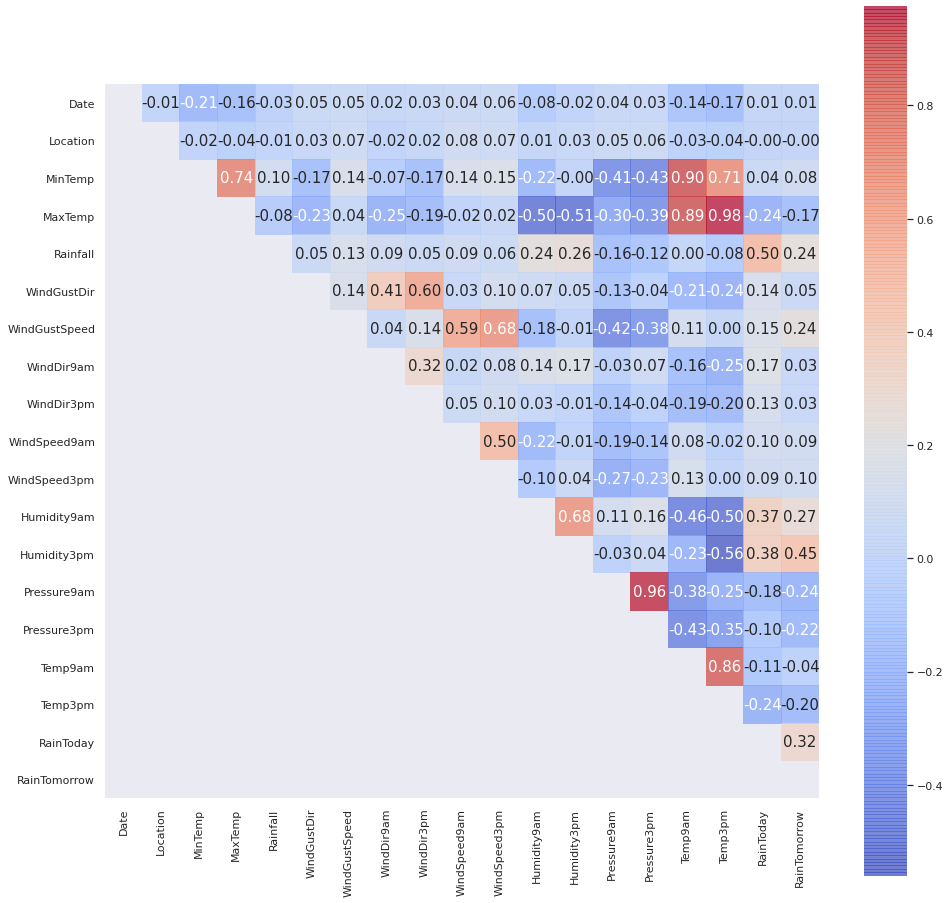

In [ ]:
corr = df[features].corr()
plt.figure(figsize=(16,16))

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

sns.heatmap(upper, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

we can see we got linear correlation  between ['Pressure9am', 'Pressire3pm'], ['Temp3pm', 'Temp9am'] and ['MaxTemp', 'Temp3pm'] with correlation of 98%
we need to drop one of the features that got more then 85% correlation 

In [ ]:
# Find features with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

next we will see the number of outliers in every features and count them

In [ ]:
features = df.drop(columns='RainTomorrow', axis=0).columns
print('The dataset contains %d observations with more than 1 outliers' %(len(outlier_remove(df[features]))))   

The dataset contains 33741 observations with more than 1 outliers


we need to drop them 

In [ ]:
outlier_indices = outlier_remove(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(89969, 16)


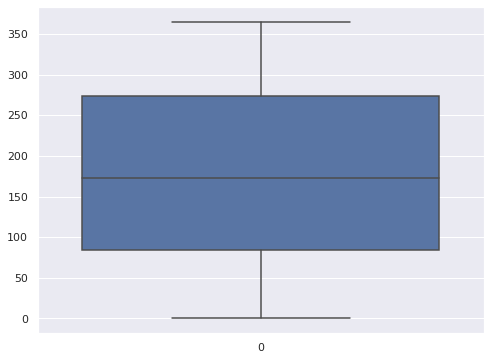

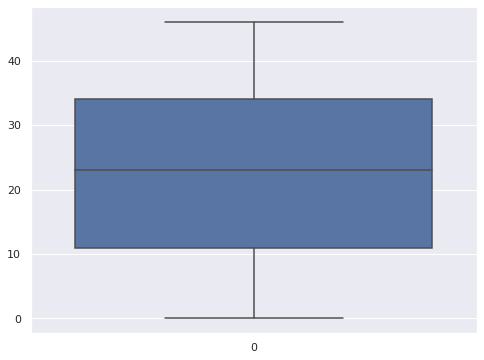

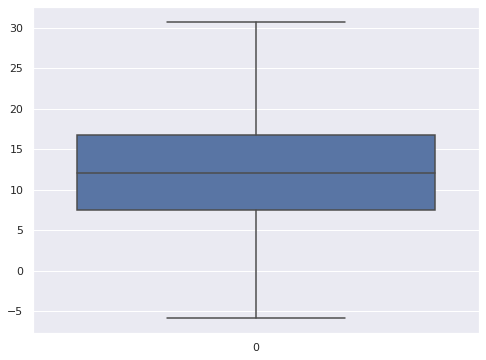

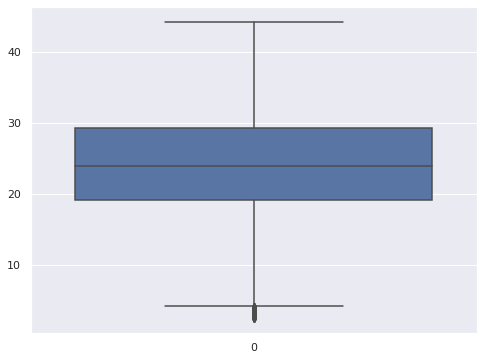

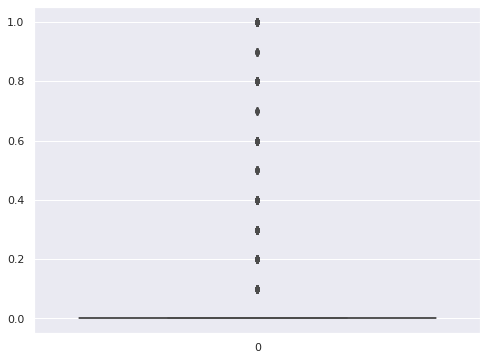

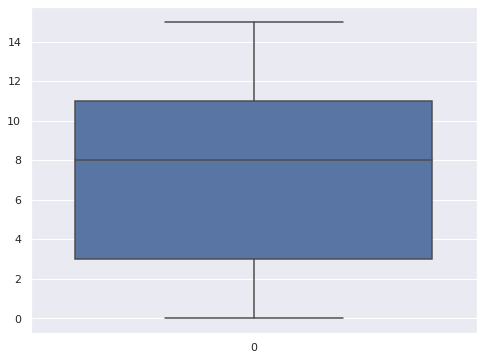

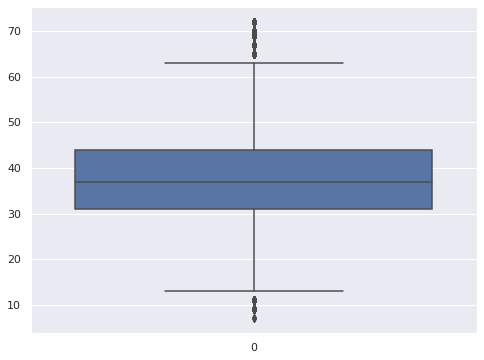

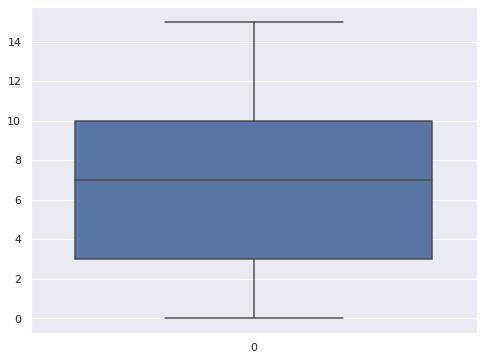

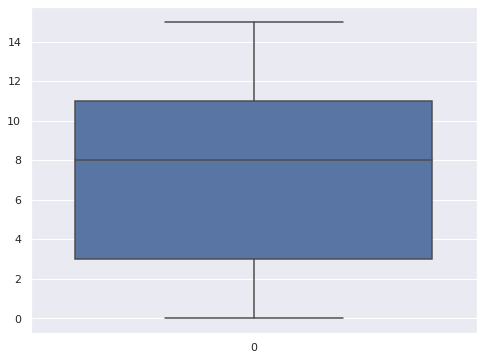

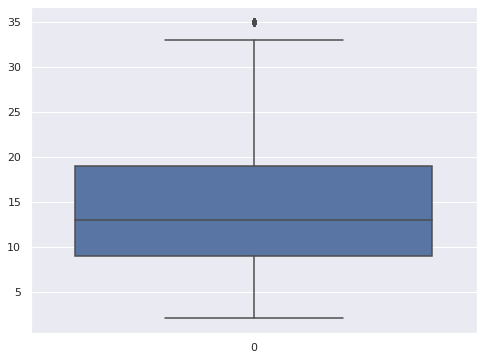

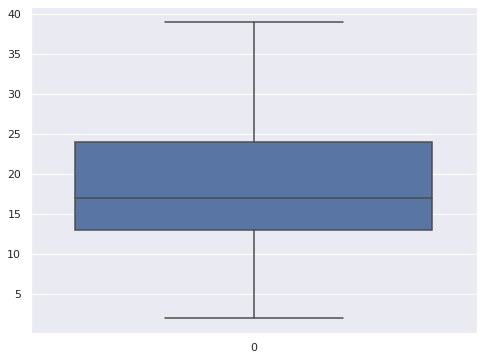

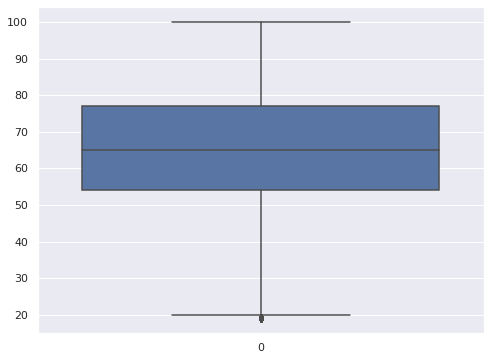

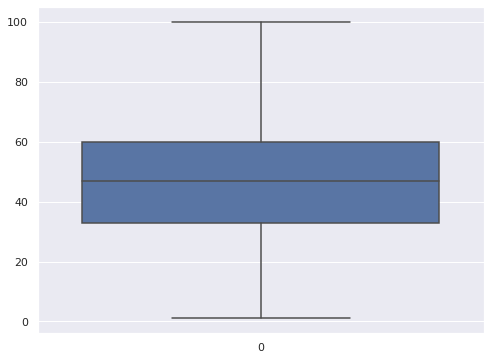

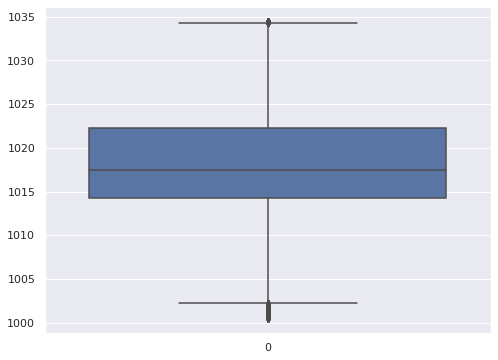

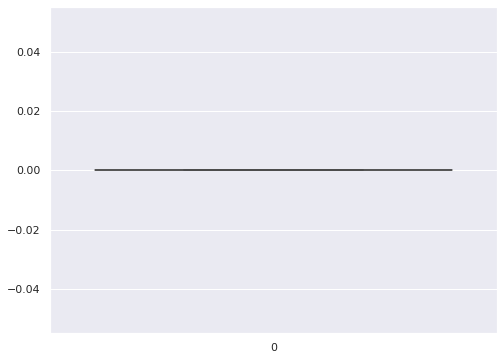

In [ ]:
for col in features:
  plt.figure(figsize=(8,6))
  sns.boxplot(data=df[col]);
  plt.show()

### - Split-out test dataset and scale the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='RainTomorrow', axis=0),
                                                    df['RainTomorrow'], test_size = 0.15 , random_state = 1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 4. Evaluate Algorithms

In [ ]:
regressor = LogisticRegression1(X_train,y_train)
 
regressor.fit(1 , 100)
 
y_pred = regressor.predict(X_train,0.5)
print('accuracy -> {}'.format(np.sum(y_pred == y_train) / y_train.shape[0]))

accuracy -> 0.8743216560093104


In [ ]:
regressor.loss_pre(X_train, y_train)

0.3186679825007224

In [ ]:
y_pred = regressor.predict(X_test,0.5)
print('accuracy -> {}'.format(np.sum(y_pred == y_test) / y_test.shape[0]))

accuracy -> 0.8755186721991701


plot the lost of the test data 

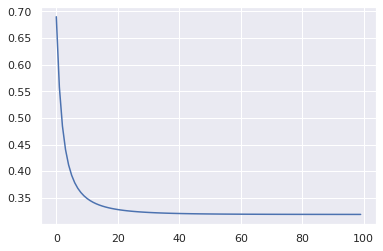

In [ ]:
plt.plot(np.arange(100), regressor.losses);

In [ ]:
regressor.loss_pre(X_test, y_test)

0.31307201057544864

In [ ]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     11547
           1       0.66      0.28      0.39      1949

    accuracy                           0.88     13496
   macro avg       0.78      0.63      0.66     13496
weighted avg       0.86      0.88      0.85     13496



In [ ]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.87462241575458

In [ ]:
model.score(X_test, y_test)

0.8757409602845287

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     11547
           1       0.66      0.28      0.40      1949

    accuracy                           0.88     13496
   macro avg       0.78      0.63      0.66     13496
weighted avg       0.86      0.88      0.85     13496

